# Imports

In [1]:
import pandas as pd
import numpy as np
import warnings
import pickle
import os
from sklearn import metrics
import seaborn as sb
import matplotlib.pyplot as plt

import json
from google.colab import drive
from google.colab import files


!pip install papermill
!pip install nbconvert
!pip install nbformat
!pip install IPython

import papermill as pm
import nbformat
from nbconvert import HTMLExporter
from IPython.display import HTML, display

from sklearn.ensemble import GradientBoostingRegressor

warnings.filterwarnings("ignore")
%matplotlib inline

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 21.9 MB/s eta 0:00:00


# Bootstrap

In [2]:
import os
from dotenv import load_dotenv

# Find and load the .env file from the current or parent directories
load_dotenv()

# Access the environment variable using os.getenv()
PROJECT_PATH = os.getenv('PROJECT_PATH')
CONFIG_FILE = f"{PROJECT_PATH}/src/config.json"

In [3]:
drive.mount('/content/drive')

with open(CONFIG_FILE, 'r') as f:
    project_config = json.load(f)
    project_config.pop('_comment', None)
    project_config.pop('_note', None)
    f.close()

Mounted at /content/drive


In [4]:
np.random.seed(31071967)

# Run project notebook N-1

In [5]:
if project_config['chain_notebooks'] == '1':

  input_file =  f"{PROJECT_PATH}{project_config['notebooks_directory']}{project_config['notebook4']}"
  output_file = f"{PROJECT_PATH}{project_config['output_directory']}{project_config['output4']}"

  # --- Execute the proviuse notebook with parameters ---
  pm.execute_notebook(
      input_path = input_file,
      output_path = output_file,
      log_output=False,  # don't print logs while running
      progress_bar=True
  )

  # --- Convert the executed notebook to HTML ---
  nb = nbformat.read(output_file, as_version=4)
  html_exporter = HTMLExporter()
  html_exporter.template_name = "lab"  # modern look; alternatives: 'classic', 'basic'
  body, _ = html_exporter.from_notebook_node(nb)

  # --- Display the HTML result inline ---
  display(HTML(body))

Output hidden; open in https://colab.research.google.com to view.

#Load pickle

In [6]:
pickle_file      = PROJECT_PATH + project_config['pickles_directory'] + project_config['pickle4']
test_pickle_file = PROJECT_PATH + project_config['pickles_directory'] + project_config['pickle4_test']

In [7]:
# Read pickle into DataFrame
df = pd.read_pickle(pickle_file)
display(df.head(1))

if project_config['split_df'] == '1':
  df_test = pd.read_pickle(test_pickle_file)
  display(df_test.tail(1))

,track_id,track_artist,track_popularity,track_album_id,playlist_id,danceability,energy,key,loudness,mode,...,release_decade,release_decade_mean_popularity,release_year_mean_popularity,playlist_genre_grouped,track_artist_mean_popularity,track_album_id_mean_popularity,playlist_id_mean_popularity,mode_mean_popularity,key_mean_popularity,playlist_genre_grouped_mean_popularity
26210,6GnhWMhgJb7uyiiPEiEkDA,Mac Miller,77,2Tyx5dLhHYkx6zeAdVaTzN,2ujrP2rPxu8ao7wNeG1ZOY,0.843,0.435,G♯/A♭,-8.442,Major,...,2010,43.817673,35.485437,Soul & Big Room EDM,67.933333,77.0,39.895522,42.769249,44.744681,32.370314


,track_id,track_artist,track_popularity,track_album_id,playlist_id,danceability,energy,key,loudness,mode,...,release_decade,release_decade_mean_popularity,release_year_mean_popularity,playlist_genre_grouped,track_artist_mean_popularity,track_album_id_mean_popularity,playlist_id_mean_popularity,mode_mean_popularity,key_mean_popularity,playlist_genre_grouped_mean_popularity
20687,4vp2J1l5RD4gMZwGFLfRAu,The Black Eyed Peas,69,36fdxiOzdlmsrHgGcfvqUJ,6a66cg3HcsjYkisYyQcov6,0.743,0.766,C,-6.375,Major,...,2000,33.36481,28.538012,Electro/Latin Pop Fusion,56.625,69.0,58.826087,42.573333,41.820202,43.353232


In [8]:
# types of cols
small_cat_cols     = ['key_mean_popularity', 'playlist_genre_grouped_mean_popularity','release_decade_mean_popularity','release_year_mean_popularity'] #'mode_mean_popularity', 'release_month_mean_popularity'
small_cat_symboles = ['mode','key','playlist_genre_grouped','release_decade','release_month', 'release_year']
large_cat_cols     = ['track_artist_mean_popularity','track_album_id_mean_popularity','playlist_id_mean_popularity']
cont_cols          = ['acousticness', 'danceability','duration_ms','energy', 'liveness', 'loudness', 'speechiness', 'tempo','valence']
y_col              = 'track_popularity'
X_cols             = large_cat_cols + small_cat_cols + cont_cols
MERGE_ON_COL       = 'track_id'

# Split

In [9]:
if project_config['split_df'] == '1':
  X_train = df[X_cols]
  y_train = df[y_col]
  X_test = df_test[X_cols]
  y_test = df_test[y_col]

else:
  from sklearn.model_selection import train_test_split
  X_train, X_temp, y_train, y_temp = train_test_split(df[X_cols], df[y_col], test_size=0.30, random_state=222)

#X_dev, X_test, y_dev, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=222)

#Regression Models

In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
import xgboost as xgb

In [11]:
def regressionMetrics(y, yhat):
    from sklearn import metrics
    import numpy as np

    y = np.array(y)
    yhat = np.array(yhat)

    y_safe = np.maximum(y, 0)
    yhat_safe = np.maximum(yhat, 0)

    res = {
        'MSE': float(metrics.mean_squared_error(y, yhat)),
        'RMSE': float(np.sqrt(metrics.mean_squared_error(y, yhat))),
        'MAE': float(metrics.mean_absolute_error(y, yhat)),
        #'RMSLE': float(np.sqrt(metrics.mean_squared_log_error(y_safe, yhat_safe))),
        'R2': float(metrics.r2_score(y, yhat)),
    }

    return res

In [12]:
def regression_and_prediction(regressor, regressor_name, X_train, y_train, X_test, y_test):

  regressor.fit(X_train, y_train)
  y_pred = regressor.predict(X_test)

  sb.scatterplot(x=y_test, y=y_pred)
  plt.title(regressor_name, fontsize=14)
  plt.xlabel("y_test", fontsize=12)
  plt.ylabel("y_pred", fontsize=12)
  plt.show()

  return y_pred

In [13]:
models_list = pd.DataFrame()

##Linear Regression

In [14]:
if project_config['model_alg'] == 'Linear Regression':
  model1 = LinearRegression()
  y_pred = regression_and_prediction(model1, "Linear Regression", X_train, y_train, X_test, y_test)

  model_dict = {'model': "Linear Regression"}
  new_row = pd.DataFrame([{**model_dict, **regressionMetrics(y_test, y_pred)}])
  models_list = pd.concat([models_list, new_row], ignore_index=True)

  models_list.sort_values(['R2','MAE','RMSE'], ascending=False).round(3)

##Decision Tree

In [15]:
if project_config['model_alg'] == 'Decision Tree' :

  model2 = DecisionTreeRegressor(random_state=1)
  y_pred = regression_and_prediction(model2, "Decision Tree", X_train, y_train, X_test, y_test)

  model_dict = {'model': "Decision Tree"}
  new_row = pd.DataFrame([{**model_dict, **regressionMetrics(y_test, y_pred)}])
  models_list = pd.concat([models_list, new_row], ignore_index=True)

##Random Forest

In [16]:
if project_config['model_alg'] =='Random Forest' :

  model3 = RandomForestRegressor(random_state=1)
  y_pred = regression_and_prediction(model3, "RandomForest", X_train, y_train, X_test, y_test)

  model_dict = {'model': "RandomForest"}
  new_row = pd.DataFrame([{**model_dict, **regressionMetrics(y_test, y_pred)}])
  models_list = pd.concat([models_list, new_row], ignore_index=True)

##Adaptive Boosting (ADABoost)



In [17]:
if project_config['model_alg'] == 'ADB' :

  model4 = AdaBoostRegressor(random_state=1)
  y_pred = regression_and_prediction(model4, "ADABoost", X_train, y_train, X_test, y_test)

  model_dict = {'model': "ADABoost"}
  new_row = pd.DataFrame([{**model_dict, **regressionMetrics(y_test, y_pred)}])
  models_list = pd.concat([models_list, new_row], ignore_index=True)

##Gradient Boosting Machine (GBM)

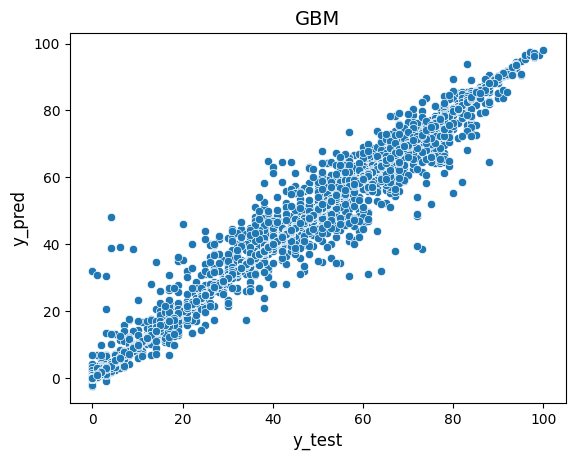

In [18]:
if project_config['model_alg'] == 'GBM' :

  model5 =  GradientBoostingRegressor(random_state=1)
  y_pred = regression_and_prediction(model5, "GBM", X_train, y_train, X_test, y_test)

  model_dict = {'model': "GBM"}
  new_row = pd.DataFrame([{**model_dict, **regressionMetrics(y_test, y_pred)}])
  models_list = pd.concat([models_list, new_row], ignore_index=True)

##Support Vector Machine (SVM)

In [19]:
if project_config['model_alg'] == 'SVM' :

  model6 =  SVR()
  y_pred = regression_and_prediction(model6, "SVM", X_train, y_train, X_test, y_test)

  model_dict = {'model': "SVM"}
  new_row = pd.DataFrame([{**model_dict, **regressionMetrics(y_test, y_pred)}])
  models_list = pd.concat([models_list, new_row], ignore_index=True)

##XGBoost

In [20]:
if project_config['model_alg'] == 'XGB' :

  model7 =  xgb.XGBRegressor()
  y_pred = regression_and_prediction(model7, "XGB", X_train, y_train, X_test, y_test)

  model_dict = {'model': "XGB"}
  new_row = pd.DataFrame([{**model_dict, **regressionMetrics(y_test, y_pred)}])
  models_list = pd.concat([models_list, new_row], ignore_index=True)

#Finetuning

<b>MSE </b>Mean Squared Error
<br><b>RMSE</b> Root Mean Squared Error
<br><b>MAE </b>Mean Absolute Error
<br><b>RMSLE</b> Root Mean Squared Logarithmic Error

In [21]:
models_list.sort_values(['R2','MAE','RMSE'], ascending=False).round(3)

,model,MSE,RMSE,MAE,R2
0,GBM,8.026,2.833,1.049,0.987


##Grid search

Fitting 5 folds for each of 48 candidates, totalling 240 fits


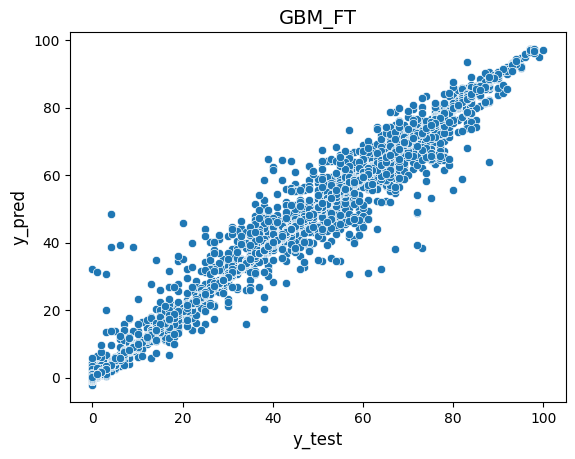

GBM_FT Best params: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 150, 'subsample': 0.8}
GBM_FT Best Score: 11.5543309341263


In [22]:
from sklearn.model_selection import GridSearchCV

gbm = GradientBoostingRegressor(random_state=42)


param_grid = {
    'n_estimators': [150],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5],
    'subsample': [0.8, 1.0],
    'min_samples_split': [2, 8],
    'min_samples_leaf': [3, 5]
}

grid_search_model = GridSearchCV(
    estimator=gbm,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=5,       # 5-fold cross-validation
    n_jobs=-1,  # Use all available cores
    verbose=3
)

pred10 = regression_and_prediction(grid_search_model, "GBM_FT", X_train, y_train, X_test, y_test)

print("GBM_FT Best params:", grid_search_model.best_params_)
print("GBM_FT Best Score:", -grid_search_model.best_score_)

model_dict = {'model': "GBM_FT"}
new_row = pd.DataFrame([{**model_dict, **regressionMetrics(y_test, pred10)}])
models_list = pd.concat([models_list, new_row], ignore_index=True)

In [23]:
models_list.sort_values(['R2','MAE','RMSE'], ascending=False).round(3)

,model,MSE,RMSE,MAE,R2
0,GBM,8.026,2.833,1.049,0.987
1,GBM_FT,8.035,2.835,1.090,0.987


##Final test

In [24]:
finalists = pd.DataFrame()
candidate1 = grid_search_model  #GBM_FT
candidate2 = model5             #GBM

In [25]:
y_pred1 = candidate1.predict(X_test) # GMB
y_pred2 = candidate2.predict(X_test) # GBM_FT

finalists_dict = {'model': "GBM"}
new_row = pd.DataFrame([{**finalists_dict, **regressionMetrics(y_test, y_pred1)}])
finalists = pd.concat([finalists, new_row], ignore_index=True)

finalists_dict = {'model': "GBM_FT"}
new_row = pd.DataFrame([{**finalists_dict, **regressionMetrics(y_test, y_pred2)}])
finalists = pd.concat([finalists, new_row], ignore_index=True)

finalists.sort_values(['R2','MAE','RMSE'], ascending=False).round(3)

,model,MSE,RMSE,MAE,R2
1,GBM_FT,8.026,2.833,1.049,0.987
0,GBM,8.035,2.835,1.090,0.987


# Pickles

In [26]:
from google.colab import files
import os

with open(f"{PROJECT_PATH}{project_config['pickles_directory']}{project_config['pickle_final_df']}", 'wb') as f:
  pickle.dump(df, f)
  f.close()


with open(f"{PROJECT_PATH}{project_config['pickles_directory']}{project_config['pickle_final_model']}", 'wb') as f:
  pickle.dump(candidate1, f)
  f.close()

In [27]:
"and... that's it"

"and... that's it"